<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Д.Р.:</b> Ссылка на дашборд (использовал уже очищенные и дополненные данные, чтобы соблюдать канву и цели моего исследования): https://public.tableau.com/views/DAR_Telecom_Final_DB/CallMePls_DB?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link   
(разрешение установлено для 1080р)
</div>

# Исследование эффективности операторов колл-центра

##  Цель проекта

Телеком-компании, предоставляющей услуги колл-центра, требуется решить задачу определить показатели эффективности операторов, а также выработать методику автоматизации определения эффективности каждого сотрудника.

Имеется два датасета: датасет с данными о звонках менеджеров (telecom_dataset.csv) и датасет с данными пользователей (telecom_clients.csv).

В датасете с данными о звонках представлены следующие поля:

* user_id - идентификатор клиента
* date - дата события
* direction - направление вызова (in - входящий, out - исходящий)
* internal - маркер внутренних вызовов между сотрудниками по ВАТС
* operator_id - идентификатор оператора
* is_missed_call - маркер пропущенного звонка
* calls_count - количество звонков
* call_duration - длительность звонка без учета времени ожидания
* total_call_duration - длительность звонка с учетом времени ожидания

В датасете с данными пользователей представлены следующие поля:

* user_id - идентификатор клиента
* tariff_plan - тарифный план клиента
* date_start - дата регистрации клиента в сервисе

Конечной целью анализа является определение эффективности работы сотрудников колл-центра, при определении критерия рассматриваются следующие показатели:

- количество пропущенных входящих вызовов
- время ожидания ответа оператора
- число исходящих вызовов для операторов, ориентированных на обзвон клиентов.

## Введение и исходные данные

Для исследования, как отмечено выше, предоставлены два датасета, в которых содержатся данные о звонках операторов колл-центров по различным направлениям. План работы будет следующим:

1. Загрузка данных и изучение датасетов (соответствие типов данных столбцам, наименования столбцов и прочее);
2. Предобработка данных: приведение данных к требуемым типам, работа с пропусками (исключение или заполнение), работа с дубликатами явными и неявными, дополнение данных (при необходимости) категориями для характерных групп;
3. Исследовательский анализ данных: составление сводных таблиц и графиков, характеризующих имеющиеся данные, отслеживание закономерностей и характерных черт;
4. Определение границ показателей эффективности операторов колл-центров;
5. Постановка статистических гипотез (не менее двух) и их проверка.

### Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go 
from plotly.subplots import make_subplots
import seaborn as sns
from scipy import stats as st

In [2]:
df1=pd.read_csv('telecom_dataset.csv')
df1

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [3]:
df2=pd.read_csv('telecom_clients.csv')
df2

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


In [4]:
print('Уникальных пользователей в датасете telecom_dataset:',df1['user_id'].nunique())

Уникальных пользователей в датасете telecom_dataset: 307


In [5]:
print('Уникальных пользователей в датасете telecom_clients:',df2['user_id'].nunique())

Уникальных пользователей в датасете telecom_clients: 732


Перед объединением датафреймов в один общий необходимо определить, какова полнота данных по пользователям в наборе данных о звонках. В данном случае больше половины известных пользователей с тарифными планами не вошли в первый датасет. Это могло произойти по разным причинам, начиная от их неактивности (то есть, существующий пользователь не совершил первый звонок или не совершал звонков за имеющийся период наблюдений) до искусственно набранной базы, состоящей из "пустых" пользователей. В данном исследовании причины этого не рассматриваются, равно как не проводятся мероприятия по дополнению данных по отсутствующим пользователям из базы.

In [6]:
df=df1.merge(df2,on='user_id',how='left')
df

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38,C,2019-10-31
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501,C,2019-10-31
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190,C,2019-10-31
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190,C,2019-10-31


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
 9   tariff_plan          53902 non-null  object 
 10  date_start           53902 non-null  object 
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 4.6+ MB


In [8]:
for col in df.columns:
    display(df[col].value_counts())

168187    2580
166658    2107
167497    1405
167626    1311
166916    1308
          ... 
166584       1
167981       1
168578       1
168013       1
166554       1
Name: user_id, Length: 307, dtype: int64

2019-11-25 00:00:00+03:00    1220
2019-11-28 00:00:00+03:00    1198
2019-11-21 00:00:00+03:00    1186
2019-11-27 00:00:00+03:00    1180
2019-11-22 00:00:00+03:00    1176
                             ... 
2019-08-03 00:00:00+03:00       9
2019-08-02 00:00:00+03:00       8
2019-08-10 00:00:00+03:00       7
2019-08-04 00:00:00+03:00       4
2019-08-11 00:00:00+03:00       2
Name: date, Length: 119, dtype: int64

out    31917
in     21985
Name: direction, dtype: int64

False    47621
True      6164
Name: internal, dtype: int64

901884.0    348
901880.0    337
893804.0    325
885876.0    319
891410.0    290
           ... 
911152.0      1
891250.0      1
962904.0      1
940512.0      1
937772.0      1
Name: operator_id, Length: 1092, dtype: int64

False    30334
True     23568
Name: is_missed_call, dtype: int64

1      14321
2       7015
3       4483
4       3342
5       2454
       ...  
995        1
519        1
314        1
464        1
748        1
Name: calls_count, Length: 502, dtype: int64

0        23263
1          200
7          144
15         126
13         125
         ...  
10061        1
57988        1
12935        1
1108         1
3296         1
Name: call_duration, Length: 5373, dtype: int64

0       1320
2        850
1        527
4        461
6        380
        ... 
2801       1
2175       1
2480       1
3337       1
2699       1
Name: total_call_duration, Length: 6040, dtype: int64

C    20061
B    18944
A    14897
Name: tariff_plan, dtype: int64

2019-09-24    2802
2019-10-16    2720
2019-08-06    2321
2019-08-13    2228
2019-08-23    2204
              ... 
2019-10-29       7
2019-10-30       5
2019-10-25       4
2019-09-25       2
2019-10-26       2
Name: date_start, Length: 66, dtype: int64

Сразу бросается в глаза наличие пропусков в некоторых столбцах датасета, а также несоответствие типа данных в некоторых столбцах (date, internal, operator_id, date_start). Приведением данных к нужным типам займемся в следующем разделе.

## Предобработка данных

В настоящем разделе проведем предобработку данных, удалим пропуски и приведем типы данных в отдельных столбцах к тому типу, который в них подразумевается (при отсутствии пропусков).

### Работа с пропусками

В первую очередь изучим пропуски и примем решение об их обработке.

In [9]:
df.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
tariff_plan               0
date_start                0
dtype: int64

Есть немногим более 8 тысяч записей с отсутствующим оператором, а также 117 записей с отсутствующим признаком звонка, совершенного по внутренней сети или вовне.

В случае маркера звонка, совершенного во внутренней сети - достоверно и даже приблизительно невозможно установить, был ли звонок совершен операторами внутри сети или во внешнем мире. По этой причине, от этих пропусков можно избавиться.

В случае отсутствия номера оператора, такие звонки невозможно использовать для целей исследования, - определения эффективности **операторов**, поэтому звонки без присвоенного оператора автоматически идут в общую статистику эффективности работы самого колл-центра, но не оператора. По этой причине, как не представляющие ценности для исследования, эти пропуски также можно убрать.

In [10]:
df=df.dropna(subset=['internal','operator_id'])
df.isna().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
tariff_plan            0
date_start             0
dtype: int64

### Корректировка типов данных

Теперь, когда пропусков нет, и они не могут оказывать влияние на типы данных в столбцах, оценим, с какими данными необходимо провести работу по приведению их в нужные типы.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45670 non-null  int64  
 1   date                 45670 non-null  object 
 2   direction            45670 non-null  object 
 3   internal             45670 non-null  object 
 4   operator_id          45670 non-null  float64
 5   is_missed_call       45670 non-null  bool   
 6   calls_count          45670 non-null  int64  
 7   call_duration        45670 non-null  int64  
 8   total_call_duration  45670 non-null  int64  
 9   tariff_plan          45670 non-null  object 
 10  date_start           45670 non-null  object 
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 3.9+ MB


Будем работать со следующими столбцами: date, internal, operator_id, date_start

In [12]:
df[['operator_id','internal']] = df[['operator_id','internal']].astype({'operator_id':int,'internal':bool})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              45670 non-null  int64 
 1   date                 45670 non-null  object
 2   direction            45670 non-null  object
 3   internal             45670 non-null  bool  
 4   operator_id          45670 non-null  int32 
 5   is_missed_call       45670 non-null  bool  
 6   calls_count          45670 non-null  int64 
 7   call_duration        45670 non-null  int64 
 8   total_call_duration  45670 non-null  int64 
 9   tariff_plan          45670 non-null  object
 10  date_start           45670 non-null  object
dtypes: bool(2), int32(1), int64(4), object(4)
memory usage: 3.4+ MB


C:\Users\Admin\AppData\Local\Temp\ipykernel_5716\3582776517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['operator_id','internal']] = df[['operator_id','internal']].astype({'operator_id':int,'internal':bool})


Выше при загрузке данных и первом рассмотрении их, можно было заметить, что в столбце date время имеет в каждой дате формат 00:00:00 - это означает, что для каждого оператора в каждом колл-центре собирается общая статистика вызовов за день. Поэтому, от указания времени в столбце date можно избавиться и привести его к дате без времени.

In [13]:
df['date']=pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df['date']=pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45670 non-null  int64         
 1   date                 45670 non-null  datetime64[ns]
 2   direction            45670 non-null  object        
 3   internal             45670 non-null  bool          
 4   operator_id          45670 non-null  int32         
 5   is_missed_call       45670 non-null  bool          
 6   calls_count          45670 non-null  int64         
 7   call_duration        45670 non-null  int64         
 8   total_call_duration  45670 non-null  int64         
 9   tariff_plan          45670 non-null  object        
 10  date_start           45670 non-null  object        
dtypes: bool(2), datetime64[ns](1), int32(1), int64(4), object(3)
memory usage: 3.4+ MB


C:\Users\Admin\AppData\Local\Temp\ipykernel_5716\2563061813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date']=pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
C:\Users\Admin\AppData\Local\Temp\ipykernel_5716\2563061813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date']=pd.to_datetime(df['date'])


In [14]:
df['date_start']=pd.to_datetime(df['date_start'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45670 non-null  int64         
 1   date                 45670 non-null  datetime64[ns]
 2   direction            45670 non-null  object        
 3   internal             45670 non-null  bool          
 4   operator_id          45670 non-null  int32         
 5   is_missed_call       45670 non-null  bool          
 6   calls_count          45670 non-null  int64         
 7   call_duration        45670 non-null  int64         
 8   total_call_duration  45670 non-null  int64         
 9   tariff_plan          45670 non-null  object        
 10  date_start           45670 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](2), int32(1), int64(4), object(2)
memory usage: 3.4+ MB


C:\Users\Admin\AppData\Local\Temp\ipykernel_5716\1455198890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_start']=pd.to_datetime(df['date_start'])


Теперь все данные имеют нужный тип, и с ними можно продолжать дальнейшую работу.

## Работа с дубликатами и дополнение данных

В настоящем разделе проведем работу с дубликатами в данных, примем решение об исключении тех или иных дубликатов, а также дополним категориальные данные в рамках определения типа колл-центра. Для этого построим вспомогательную таблицу, где для каждого клиента подберем соответствующего ему оператора, подсчитаем для каждого оператора количество входящих и исходящих звонков, и на основе соотношения таких звонков определим границы групп принадлежности клиентов. Полученными группами дополним основной датасет.

### Работа с дубликатами

Проверим наличие дубликатов в датасете.

In [15]:
duplicates = df[df.duplicated()]
duplicates

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
8,166377,2019-08-05,out,False,880020,True,8,0,50,B,2019-08-01
44,166377,2019-08-14,out,False,880026,False,10,1567,1654,B,2019-08-01
51,166377,2019-08-15,out,False,880026,False,11,1413,1473,B,2019-08-01
62,166377,2019-08-19,out,False,880026,False,14,1519,1598,B,2019-08-01
78,166377,2019-08-22,out,False,880026,True,6,0,55,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
53861,168601,2019-11-20,out,False,952914,True,1,0,2,C,2019-10-31
53869,168601,2019-11-25,in,False,952914,False,7,1229,1282,C,2019-10-31
53874,168601,2019-11-26,in,False,952914,False,4,539,562,C,2019-10-31
53885,168603,2019-11-20,out,False,959118,True,3,0,89,B,2019-10-31


Всего было найдено 4179 записей с дублирующимися данными. В общем количестве данных это не так уж и много, поэтому для избавления от "шумов" в данных в дальнейшем, от этих дубликатов можно избавиться.

In [16]:
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 53899
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41491 non-null  int64         
 1   date                 41491 non-null  datetime64[ns]
 2   direction            41491 non-null  object        
 3   internal             41491 non-null  bool          
 4   operator_id          41491 non-null  int32         
 5   is_missed_call       41491 non-null  bool          
 6   calls_count          41491 non-null  int64         
 7   call_duration        41491 non-null  int64         
 8   total_call_duration  41491 non-null  int64         
 9   tariff_plan          41491 non-null  object        
 10  date_start           41491 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](2), int32(1), int64(4), object(2)
memory usage: 3.1+ MB


In [17]:
duplicates = df[df.duplicated()]
duplicates

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start


В качестве итога осталась 41491 запись, были удалены полные дубликаты. Теперь датасет более готов к анализу, но ему еще недостает нескольких дополнительных колонок, которые пригодятся в будущем.

### Категоризация и дополнение оставшихся данных

В данных имеются сведения о длительности звонка с учетом времени ожидания и длительности "чистого" звонка. Однако, одной из основных метрик качества работы оператора колл-центра (далее возможно использование аббревиатуры "КЦ") является время ожидания клиента на линии. Поэтому дополним данные столбцом wait_time, который будет это показывать.

In [18]:
df['wait_time'] = df['total_call_duration'] - df['call_duration']
df.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_time
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,5
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,1
3,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,8
4,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,25
5,166377,2019-08-05,out,False,880020,False,2,3,29,B,2019-08-01,26


В отрасли колл-центров как правило есть три основных направления их работы: работа на исходящие вызовы (обзвоны, телемаркетинг, опросы, "служба безопасности банка"), работа на входящие вызовы (горячая линия, консультации), и работа в обе стороны (клиентский сервис, ресепшен/УАТС). Поэтому для исследования будет весьма важно определить принадлежность рассматриваемого КЦ к тому или иному типу, поскольку к оценке эффективности могут применяться различные показатели.

In [19]:
df_temp=df.query('internal == False').pivot_table(index='user_id',columns='direction',values='calls_count',aggfunc='sum').reset_index()
df_temp['in']=df_temp['in'].fillna(value=0)
df_temp['out']=df_temp['out'].fillna(value=0)
df_temp

direction,user_id,in,out
0,166377,102.0,4897.0
1,166391,4.0,0.0
2,166392,102.0,0.0
3,166399,11.0,0.0
4,166405,2191.0,9789.0
...,...,...,...
285,168583,22.0,0.0
286,168598,21.0,0.0
287,168601,79.0,586.0
288,168603,0.0,14.0


In [20]:
df_temp['out_share']=df_temp['out']/(df_temp['in']+df_temp['out'])*100
df_temp['in_share']=df_temp['in']/(df_temp['in']+df_temp['out'])*100
df_temp

direction,user_id,in,out,out_share,in_share
0,166377,102.0,4897.0,97.959592,2.040408
1,166391,4.0,0.0,0.000000,100.000000
2,166392,102.0,0.0,0.000000,100.000000
3,166399,11.0,0.0,0.000000,100.000000
4,166405,2191.0,9789.0,81.711185,18.288815
...,...,...,...,...,...
285,168583,22.0,0.0,0.000000,100.000000
286,168598,21.0,0.0,0.000000,100.000000
287,168601,79.0,586.0,88.120301,11.879699
288,168603,0.0,14.0,100.000000,0.000000


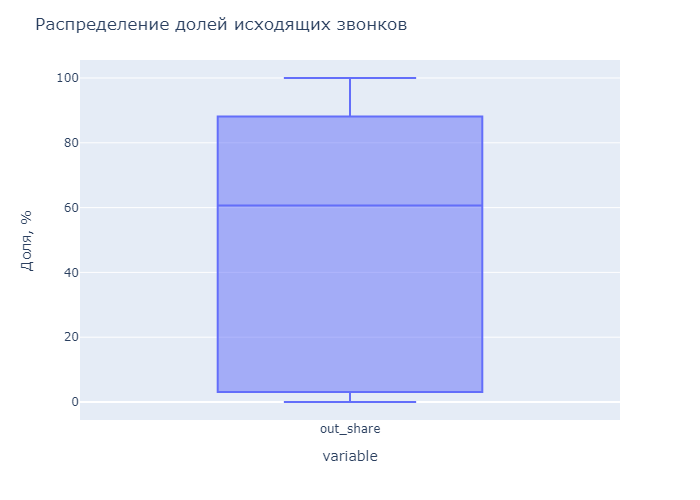

In [21]:
fig = px.box(df_temp, y=['out_share'])
fig.update_layout(title="Распределение долей исходящих звонков",
                  yaxis_title="Доля, %",
                  showlegend=False)
fig.show("png")

Судя по диаграмме распределения, есть колл-центры, в которых встречаются только входящие, либо только исходящие звонки. При этом медианное значение для доли исходящих звонков составляет 60.67%, а для входящих соответственно - 39.32%. При этом, в промежутке между этими значениями будут находится колл-центры, ориентированные на работу с исходящими и входящими звонками одновременно.

Для категоризации КЦ по направлениям работы, можем принять, что КЦ с долей исходящих звонков более 61% процента (округленное вверх медианное значение) - ориентированы на исходящие взаимодействия, КЦ с долей входящих звонков более 61% - ориентированы на входящее взаимодействие, а все остальные - ориентированы на двустороннее взаимодействие.

Принимая такое допущение, введем критерии 'outbound' для КЦ, работающих на исходящие значения, 'inbound' - на входящие, и 'middle' - на двустороннее взаимодействие.

In [22]:
def cc_cat(row):
    call_out = row['out_share']
    call_in = row['in_share']
    if call_out >= 61:
        return 'outbound'
    elif call_in >= 61 :
        return 'inbound'
    else:
        return 'middle'

df_temp['cc_type'] = df_temp.apply(cc_cat, axis=1)
df_temp

direction,user_id,in,out,out_share,in_share,cc_type
0,166377,102.0,4897.0,97.959592,2.040408,outbound
1,166391,4.0,0.0,0.000000,100.000000,inbound
2,166392,102.0,0.0,0.000000,100.000000,inbound
3,166399,11.0,0.0,0.000000,100.000000,inbound
4,166405,2191.0,9789.0,81.711185,18.288815,outbound
...,...,...,...,...,...,...
285,168583,22.0,0.0,0.000000,100.000000,inbound
286,168598,21.0,0.0,0.000000,100.000000,inbound
287,168601,79.0,586.0,88.120301,11.879699,outbound
288,168603,0.0,14.0,100.000000,0.000000,outbound


Теперь уберем из временного датасета все столбцы кроме user_id и cc_type и соединим его с основным датасетом.

In [23]:
df_temp = df_temp.drop(columns=['in','out','out_share','in_share'])
df = df.merge(df_temp,on='user_id',how='left')
df

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_time,cc_type
0,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,5,outbound
1,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,1,outbound
2,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,8,outbound
3,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,25,outbound
4,166377,2019-08-05,out,False,880020,False,2,3,29,B,2019-08-01,26,outbound
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41486,168606,2019-11-09,out,False,957922,False,4,551,593,C,2019-10-31,42,outbound
41487,168606,2019-11-10,out,True,957922,False,1,0,25,C,2019-10-31,25,outbound
41488,168606,2019-11-10,out,True,957922,True,1,0,38,C,2019-10-31,38,outbound
41489,168606,2019-11-11,out,True,957922,False,2,479,501,C,2019-10-31,22,outbound


In [24]:
df.to_csv('telecom_fin_tableau.csv',index=False)

Теперь в датасете есть дополнительная информация, которая в дальнейшем позволит провести более детальное исследование и рассмотреть эффективность сотрудников колл-центров различной направленности.

## Исследовательский анализ данных

В рамках исследовательского анализа данных изучим основные характеристики данных, их распределени и взаимосвязь. Также построим иллюстрирующие ситуацию графики и диаграммы.

### Распределение показателей

Для начала взглянем на датасет, с которым будем далее работать, в общем и рассмотрим распределение показателей по столбцам, построив гистограммы распределения и выведя описательные статистики.

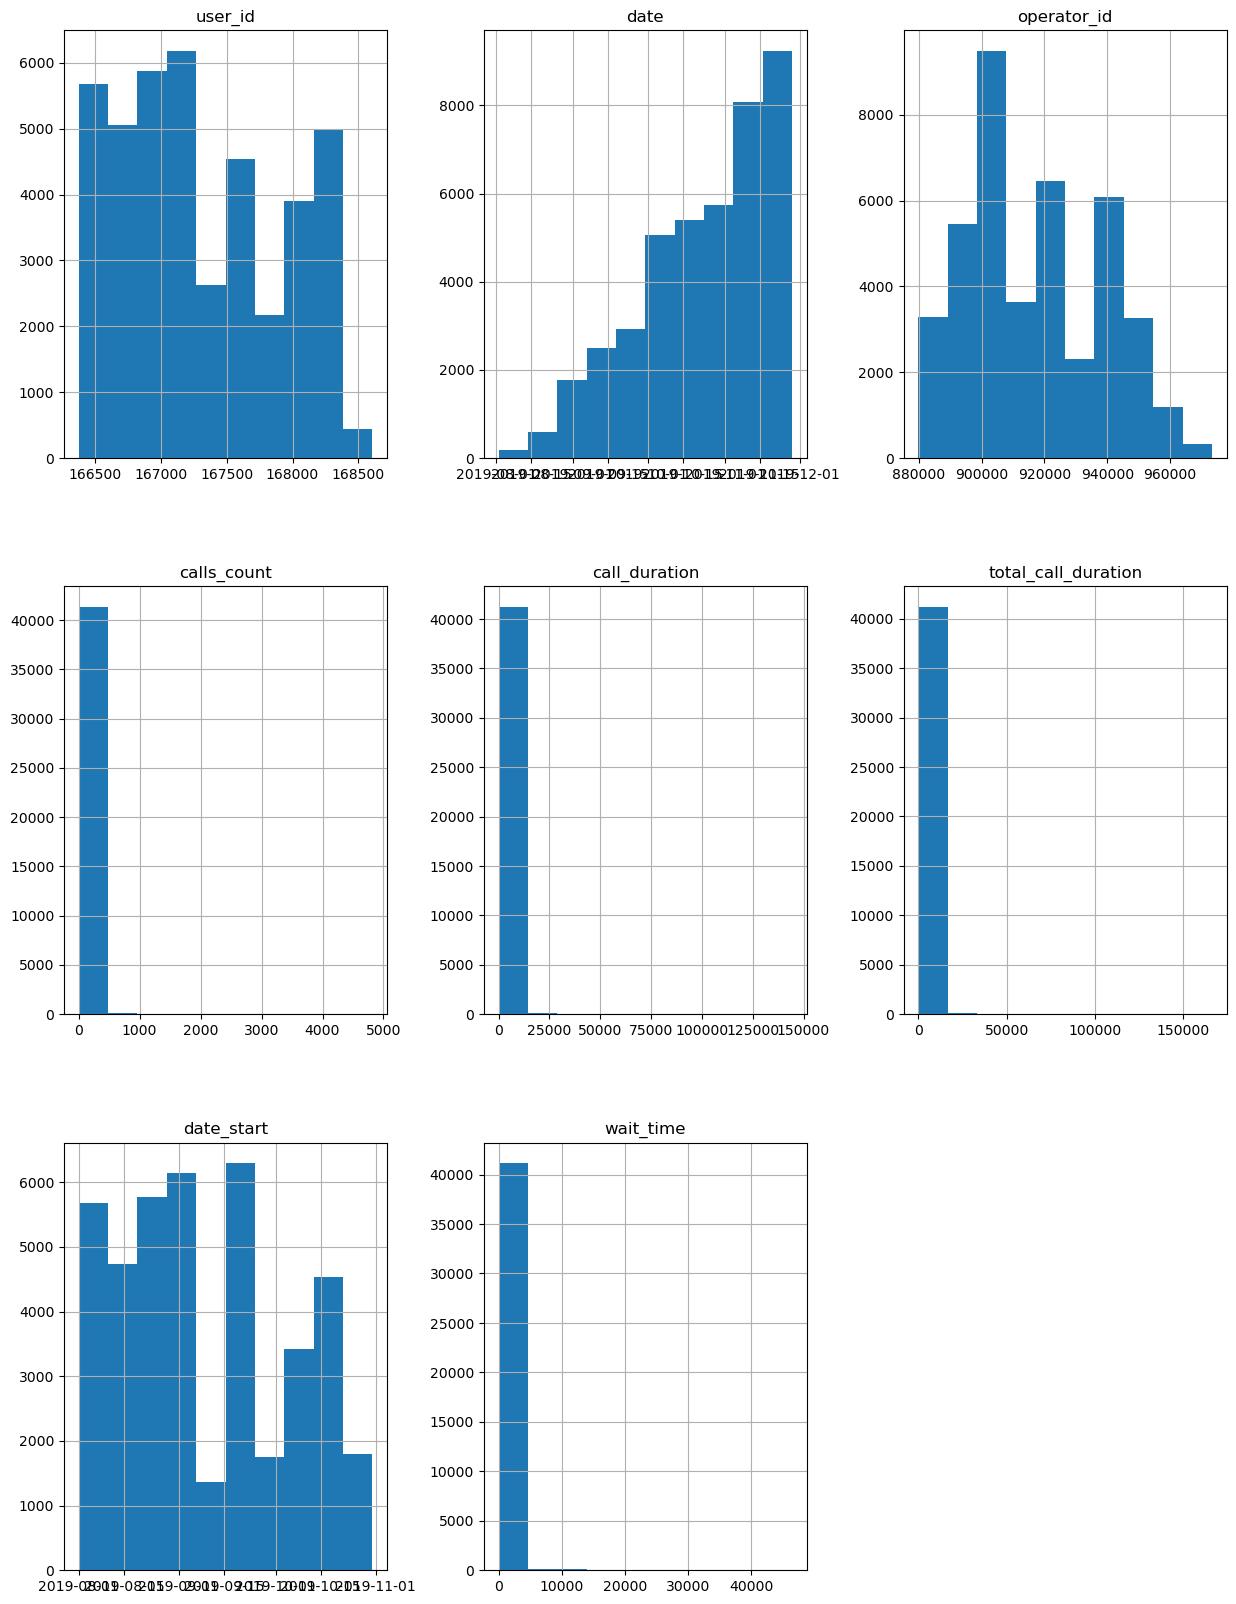

In [25]:
df.hist(figsize=(15, 20))
plt.show()

In [26]:
df.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,wait_time
count,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000
mean,167301.113543,916516.771155,16.921381,1010.940011,1323.153238,312.213227
std,600.513986,21234.081589,59.786187,4066.666485,4788.953155,1176.102940
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,900790.000000,1.000000,0.000000,67.000000,19.000000
50%,167175.000000,913938.000000,4.000000,106.000000,289.000000,60.000000
75%,167827.000000,937708.000000,14.000000,772.000000,1107.000000,219.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000,46474.000000


Из полученных данных можно обратить внимание на то, что среднее число звонков составляет 16,92; средняя длительность разговора составляет 1010.94 секунды (или 16,84 минут); средняя длительность звонка с ожиданием составляет 1323,15 секунд (или 22,05 минут); среднее время ожидания на линии - 312,21 секунд (или 5,2035 минут).

Рассмотрим распределение категориальных показателей.

In [27]:
pivot_dir = df.pivot_table(index='direction',values='calls_count',aggfunc='sum').reset_index()
pivot_dir

,direction,calls_count
0,in,93742
1,out,608343


In [28]:
pivot_int = df.pivot_table(index='internal',values='calls_count',aggfunc='sum').reset_index()
pivot_int

,internal,calls_count
0,False,688420
1,True,13665


In [29]:
pivot_miss = df.pivot_table(index='is_missed_call',values='calls_count',aggfunc='sum').reset_index()
pivot_miss

,is_missed_call,calls_count
0,False,429767
1,True,272318


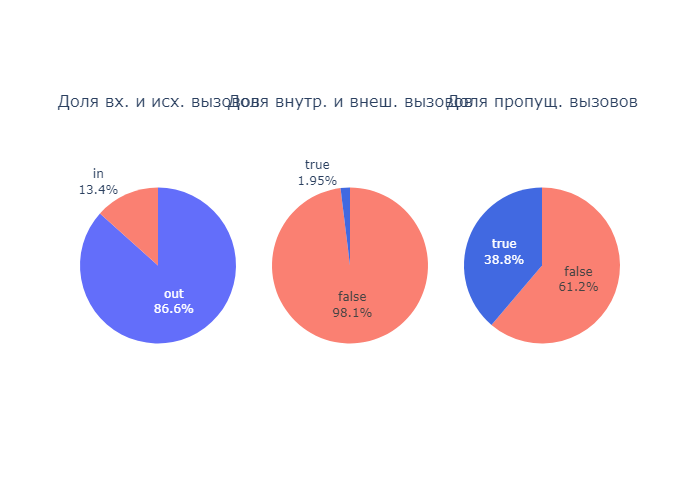

In [30]:
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"}]],
                   subplot_titles=['Доля вх. и исх. вызовов', 'Доля внутр. и внеш. вызовов','Доля пропущ. вызовов'])


fig.add_trace(go.Pie(
     values=pivot_dir['calls_count'],
     labels=pivot_dir['direction'],
     marker_colors=['Salmon','Royal Blue'],
     domain=dict(x=[0, 0.5])), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=pivot_int['calls_count'],
     labels=pivot_int['internal'],
    marker_colors=['Salmon','RoyalBlue'],
     domain=dict(x=[0.5, 1.0])),
    row=1, col=2)

fig.add_trace(go.Pie(
     values=pivot_miss['calls_count'],
     labels=pivot_miss['is_missed_call'],
    marker_colors=['Salmon','RoyalBlue'],
     domain=dict(x=[0.5, 1.0])),
    row=1, col=3)

fig.update_traces(textinfo='percent+label',hoverinfo='label+percent')
fig.update(layout_showlegend=False)
fig.show("png")

Итого:
* Операторы совершают 86,6% исходящих вызовов против 13,4% входящих;
* Из всего количества только 1,95% вызовов внутренние;
* Достаточно велико на общем фоне количество пропущенных вызовов: 38,8% не принимаются по той или иной причине (сами причины неизвестны). 

В дальнейшем анализе мы **не будем учитывать внутренние вызовы**, поскольку нас интересует только работа операторов колл-центров во взаимодействии с внешними контактами, а не между собой. При этом данные о внутренних вызовах из датасета исключать не будем, поскольку они понадобятся в дальнейшем при определении показателей эффективности оператора в качестве дополняющего фактора к остальным метрикам.

Также, поскольку у нас имеются данные по тарифным планам и категориальные данные по направленностям КЦ, можем также рассмотреть, в каких долях они представлены.

In [31]:
pivot_tariff = df.pivot_table(index=['tariff_plan'],values=['user_id'],aggfunc=lambda x: len(x.unique())).reset_index()
pivot_tariff

,tariff_plan,user_id
0,A,32
1,B,101
2,C,157


In [32]:
pivot_type = df.pivot_table(index=['cc_type'],values=['user_id'],aggfunc=lambda x: len(x.unique())).reset_index()
pivot_type

,cc_type,user_id
0,inbound,116
1,middle,30
2,outbound,144


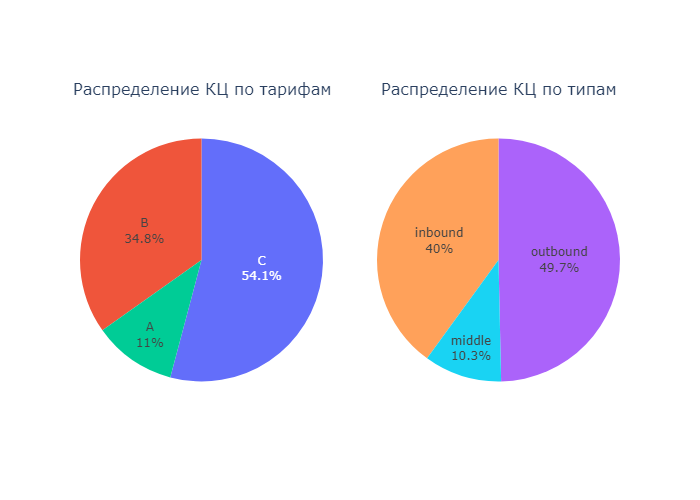

In [33]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],
                   subplot_titles=['Распределение КЦ по тарифам', 'Распределение КЦ по типам'])


fig.add_trace(go.Pie(
     values=pivot_tariff['user_id'],
     labels=pivot_tariff['tariff_plan'],
     domain=dict(x=[0, 0.5])), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=pivot_type['user_id'],
     labels=pivot_type['cc_type'],
     domain=dict(x=[0.5, 1.0])),
    row=1, col=2)

fig.update_traces(textinfo='percent+label',hoverinfo='label+percent')
fig.update(layout_showlegend=False)
fig.show("png")

Итого, в датасете есть 54.1% колл-центров с тарифом С, 34,8% колл-центров с тарифом В и 11% колл-центров с тарифом А.

Среди всех колл-центров 49,7% ориентированы на исходящий обзвон, 40% - на входящие звонки, и 10,3% работают со звонками обоих типов.

Тем не менее, похожие доли могут не означать, что какой-то конкретный тарифный план ориентирован на направление звонка. Отрасль колл-центров имеет тенденцию вводить разные уровни тарификации в зависимости от количества задействованных операторов. Эти распределения рассмотрим позже.

### Средние показатели по датам

Дополнительно, справочно покажем, какие временные рамки рассматриваются, а также покажем минимальную и максимальную даты регистрации колл-центров в системе.

In [34]:
print('Минимальная дата совершения звонка',df['date'].min())
print('Максимальная дата совершения звонка',df['date'].max())
print('Минимальная дата регистрации КЦ',df['date_start'].min())
print('Максимальная дата регистрации КЦ',df['date_start'].max())

Минимальная дата совершения звонка 2019-08-02 00:00:00
Максимальная дата совершения звонка 2019-11-28 00:00:00
Минимальная дата регистрации КЦ 2019-08-01 00:00:00
Максимальная дата регистрации КЦ 2019-10-31 00:00:00


Итого получается, что в датасете есть колл-центры, зарегистрированные в компании с 01 августа 2019 года по 31 октября 2019 года, а звонки этими колл-центрами совершаются с 02 августа 2019 года по 28 ноября 2019 года. Таким образом, даже для самых недавно зарегистрированных колл-центров могут быть доступны данные как минимум за 4 недели их работы.

В первую очередь изучим количество активных операторов на каждую дату, количество звонков, ими совершаемых, а также изменение среднего времени длительности звонков изо дня в день. Дополнительно введем информационную колонку с днем недели.

In [35]:
timetable = df.query('internal == False').pivot_table(index=['date'],values=['operator_id','calls_count','call_duration','total_call_duration'],
                                                     aggfunc={'operator_id':'nunique',
                                                              'calls_count':'sum',
                                                              'call_duration':'mean',
                                                              'total_call_duration':'mean'}).reset_index()
timetable

,date,call_duration,calls_count,operator_id,total_call_duration
0,2019-08-02,34.750000,16,2,111.750000
1,2019-08-03,190.400000,26,2,281.800000
2,2019-08-04,57.000000,2,1,70.000000
3,2019-08-05,836.000000,176,4,1048.666667
4,2019-08-06,930.166667,178,7,1079.083333
...,...,...,...,...,...
113,2019-11-24,1045.790244,3326,114,1349.043902
114,2019-11-25,1025.177340,13395,397,1303.439655
115,2019-11-26,1039.845855,12899,385,1329.341969
116,2019-11-27,936.523114,12525,414,1192.985401


In [36]:
timetable['day_of_week'] = timetable['date'].dt.day_name()
timetable['calls_per_operator'] = round(timetable['calls_count']/timetable['operator_id'],2)
timetable

,date,call_duration,calls_count,operator_id,total_call_duration,day_of_week,calls_per_operator
0,2019-08-02,34.750000,16,2,111.750000,Friday,8.00
1,2019-08-03,190.400000,26,2,281.800000,Saturday,13.00
2,2019-08-04,57.000000,2,1,70.000000,Sunday,2.00
3,2019-08-05,836.000000,176,4,1048.666667,Monday,44.00
4,2019-08-06,930.166667,178,7,1079.083333,Tuesday,25.43
...,...,...,...,...,...,...,...
113,2019-11-24,1045.790244,3326,114,1349.043902,Sunday,29.18
114,2019-11-25,1025.177340,13395,397,1303.439655,Monday,33.74
115,2019-11-26,1039.845855,12899,385,1329.341969,Tuesday,33.50
116,2019-11-27,936.523114,12525,414,1192.985401,Wednesday,30.25


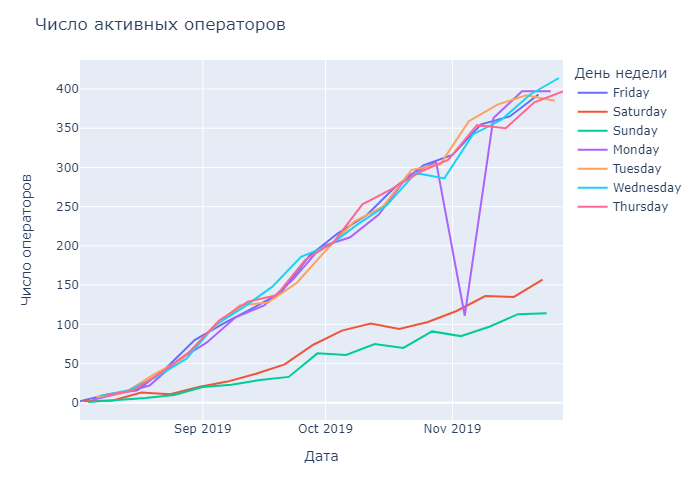

In [37]:
fig = px.line(timetable, x="date", y=["operator_id"],color='day_of_week')
fig.update_layout(title='Число активных операторов',
                   xaxis_title='Дата',
                   yaxis_title='Число операторов',
                 legend_title_text='День недели')
fig.show("png")

Интересно увидеть, что на момент старта работы сервиса операторов было совсем мало (два - 2 августа 2019). Затем их количество постепенно увеличивалось. Однако, в выходные дни количество активных операторов стабильно меньше - сказывается то, что работа в выходные дни оплачивается в двойном размере. И особенно примечательно, что именно 4 ноября 2019 года (понедельник) наблюдается "провал" в числе активных операторов - это означает, что, во-первых, сервис работает по российским законам, а во-вторых, - что в праздничные дни работает примерно столько же операторов, сколько в субботу.

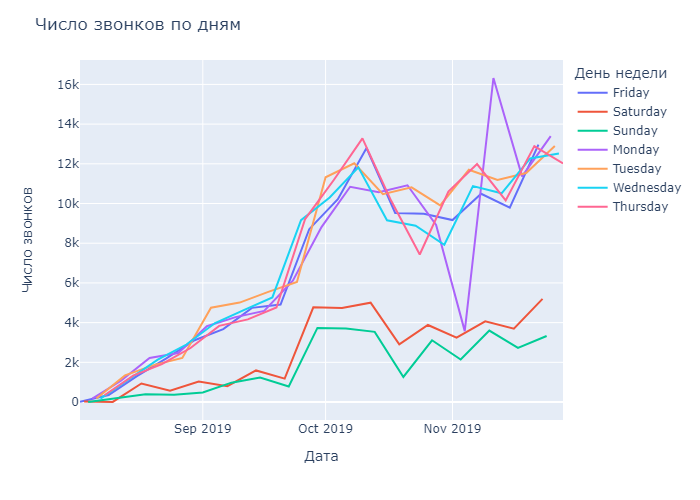

In [38]:
fig = px.line(timetable, x="date", y=["calls_count"],color='day_of_week')
fig.update_layout(title='Число звонков по дням',
                   xaxis_title='Дата',
                   yaxis_title='Число звонков',
                 legend_title_text='День недели')
fig.show("png")

С числом звонков также наблюдается заметно более низкое их количество в выходные и праздничные дни, как и с числом активных операторов. При этом, после 15 сентября начинается резкий рост их числа, и максимума их число достигает в районе 9-11 октября. Причина этого может быть любая, от самых простых (происшествия, запуск рекламных акций, рост заказов/возвратов), до максимально неочевидных (10 число каждого месяца - как правило, зарплатный день, и люди могут получать звонки от банков настоящих и от "служб безопасности банка" с определенными целями). Также, второй пик наблюдается 11 ноября - а этом может быть связано с резко выросшим числом заказов, которые колл-центр подтверждает, поскольку 11.11 обычно устраивается распродажа "черная пятница/понедельник".

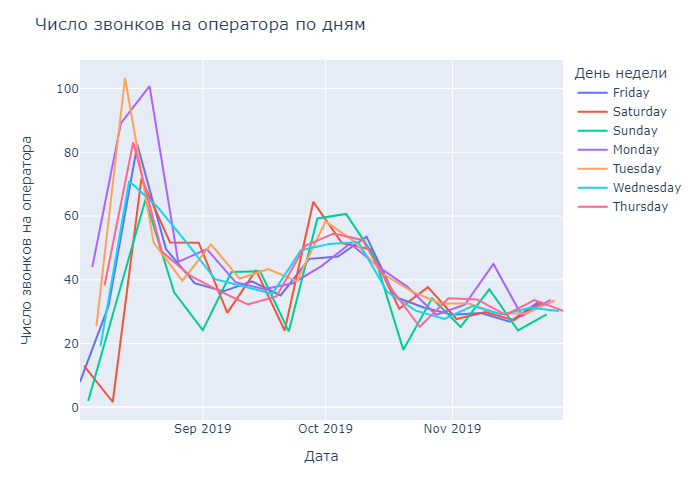

In [39]:
fig = px.line(timetable, x="date", y=["calls_per_operator"],color='day_of_week')
fig.update_layout(title='Число звонков на оператора по дням',
                   xaxis_title='Дата',
                   yaxis_title='Число звонков на оператора',
                 legend_title_text='День недели')
fig.show("png")

Рассматривая число звонков на оператора в разрезе каждого дня активности сервиса, мы видим, что ежедневная нагрузка на оператора с течением времени снижается. Собственно, в первые недели существования сервиса, когда число операторов было малым, на каждого из них в пике приходилось до 103 звонков. Это, в свою очередь, могло значительно сказываться на их общей эффективности работы.

В дальнейшем это число снижалось, делая небольшой подъем в первых числах октября (что совпадает с ростом общего количества звонков в эти дни на предыдущем графике, и также в районе 10-11 ноября, что также совпадает с предыдущим графиком. Таким образом выходит, что в сервисе при одновременном росте числа звонков и числа активных операторов, число звонков на оператора снижается, тем самым уменьшая общую рабочую нагрузку на одного человека, и, возможно, повышая его общую удовлетворенность от проделанной работы, а с ней и эффективность.

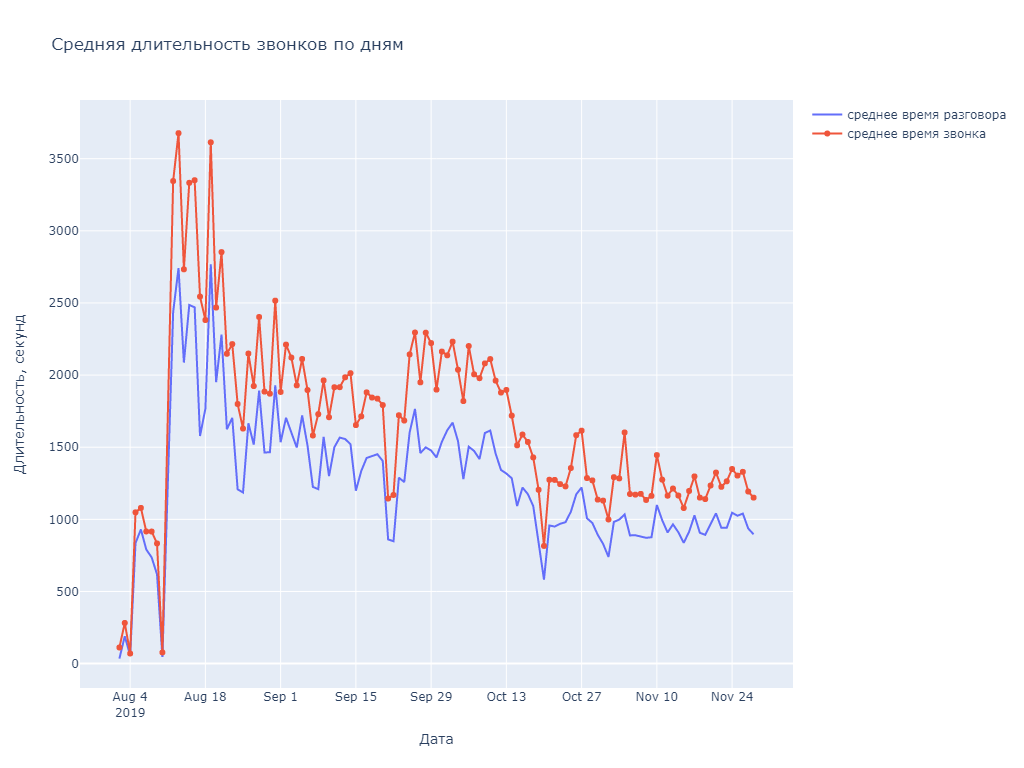

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=timetable['date'], y=timetable['call_duration'],
                    mode='lines',
                    name='среднее время разговора'))
fig.add_trace(go.Scatter(x=timetable['date'], y=timetable['total_call_duration'],
                    mode='lines+markers',
                    name='среднее время звонка'))
fig.update_layout(width=1024,
                  height=768,
                    title='Средняя длительность звонков по дням',
                   xaxis_title='Дата',
                   yaxis_title='Длительность, секунд')
fig.show("png")

На совместном графике видно, что среднее время звонка и разговора со временем уменьшается, причем наблюдаются сравнительно большие изменения в длительности разговора по выходным. При этом прослеживается и общий тренд к тому, что среднее время и разговора и звонка уменьшается. Если принять во внимание соответствующий рост числа активных операторов, числа совершаемых звонков и количества звонков на оператора, то в результате можно предположить, что уровень навыка оператора растет, операторы обучают новые кадры, и по итогу растет общая эффективность сервиса в части охватов целевых контактов.

### Характеристики показателей для типов колл-центров

Рассмотрим основные характеристики показателей для различных колл-центров по их типам. В частности, рассмотрим, как распределяются по типа колл-центров количество задействованных операторов, количество звонков, их длительность, время ожидания и успешность вызовов (пропущен вызов или нет).

In [41]:
cc_type_gen = df.query('internal == False').pivot_table(index=['cc_type','direction','is_missed_call'],values=['user_id','operator_id','calls_count','call_duration','total_call_duration','wait_time'],
                                                     aggfunc={'user_id':'nunique',
                                                              'operator_id':'nunique',
                                                              'calls_count':'sum',
                                                              'call_duration':'mean',
                                                              'total_call_duration':'mean',
                                                              'wait_time':'mean'}).reset_index()
cc_type_gen

,cc_type,direction,is_missed_call,call_duration,calls_count,operator_id,total_call_duration,user_id,wait_time
0,inbound,in,False,788.228212,28021,237,917.417877,116,129.189665
1,inbound,in,True,13.392157,212,60,40.699346,40,27.307190
2,inbound,out,False,370.778267,2783,75,422.671072,42,51.892805
3,inbound,out,True,0.000000,1517,75,59.830149,40,59.830149
4,middle,in,False,1233.099730,24008,101,1390.414555,30,157.314825
5,middle,in,True,73.513761,317,49,111.637615,17,38.123853
6,middle,out,False,920.830084,19069,96,1118.467967,27,197.637883
7,middle,out,True,0.000000,11456,99,215.842105,30,215.842105
8,outbound,in,False,700.014207,40121,399,773.019051,127,73.004843
9,outbound,in,True,13.000000,372,122,29.321918,57,16.321918


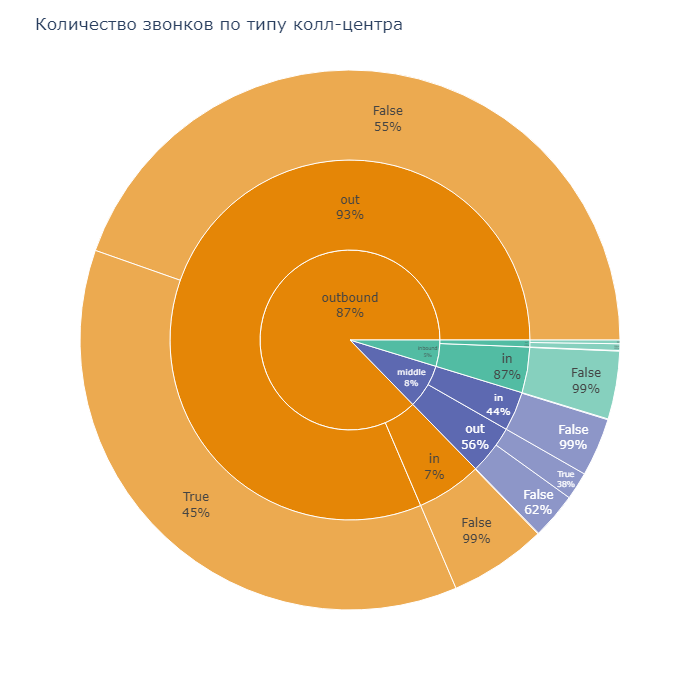

In [42]:
fig = px.sunburst(cc_type_gen, path=['cc_type','direction', 'is_missed_call'], values='calls_count', color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_layout(title='Количество звонков по типу колл-центра',
                  width=700,
                  height=700)
fig.update_traces(textinfo='label+percent parent', insidetextorientation='horizontal')
fig.show("png")

* На КЦ с исходящими звонками приходится 87% всех совершенных вызовов, они совершают 93% исходящих звонков и 7% входящих, и из этого количества 45% исходящих звонков адресатами не принимаются, среди входящих принимается 99% звонков. 

* На колл-центры, работающие в оба направления, приходится всего 8% всех звонков, но из них не принимается 1% входящих и 38% исходящих звонков. 

* Колл-центры, работающие по входящим обращениям, занимают всего 5% от общего числа звонков. Они получили 87% входящих звонков и 13% исходящих, при этом из входящих звонков был пропущен всего 1% звонков, в то время как исходящих звонков не было принято 35%.

Здесь можно заметить закономерность, что у всех типов колл-центров из исходящих звонков не принимается от 35% до 45%. Это вполне логично может быть связано с тем, что многие абоненты не любят разного рода рекламные звонки, часто запоминают номера колл-центров, и, если звонка они не ждут, скорее пропустят звонок с неизвестного номера, похожего на номер колл-центра. Тем не менее, чуть больше половины успешных исходящих звонков у специализированных КЦ с учетом объема - это достаточно высокий показатель при условии, что такие звонки приносят новых клиентов или выручку.

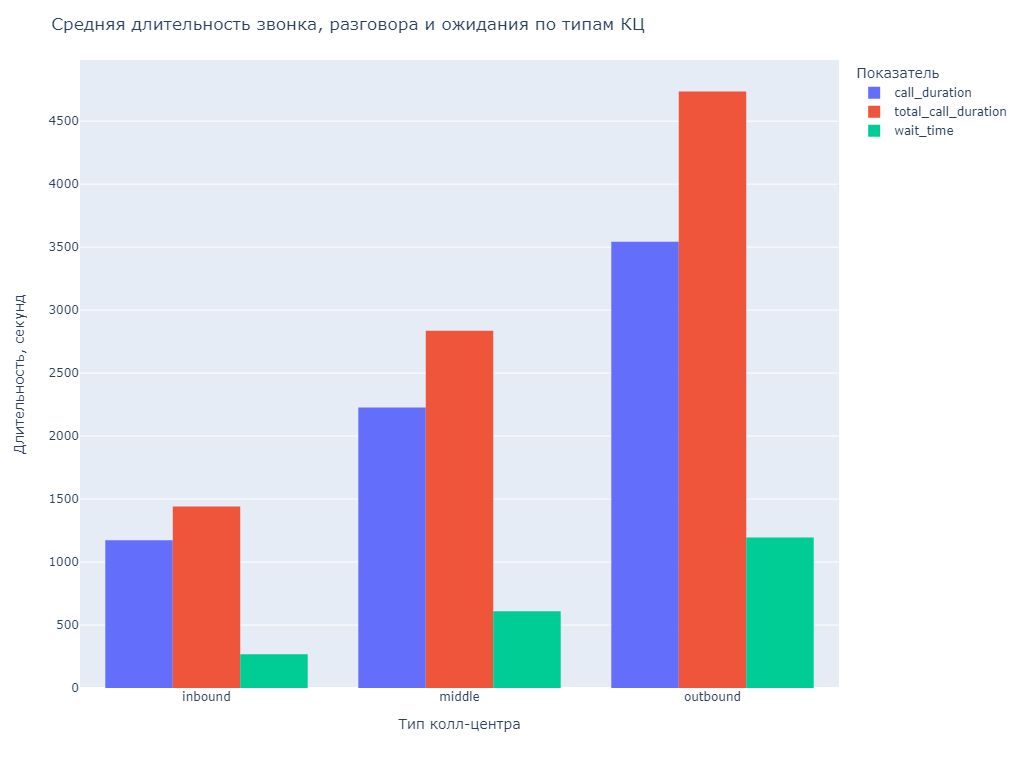

In [43]:
fig= px.histogram(cc_type_gen, x="cc_type", y=['call_duration','total_call_duration','wait_time'],barmode='group')
fig.update_layout(width=1024,
                  height=768,
                    title='Средняя длительность звонка, разговора и ожидания по типам КЦ',
                   xaxis_title='Тип колл-центра',
                   yaxis_title='Длительность, секунд',
                 legend_title_text='Показатель')
fig.show("png")

На диаграмме явно видно, что наименьшее время ожидания и разговора у колл-центров, работающих с входящими обращениями. В среднем, время разговора в них составляет 1172 секунды (или 19,53 минуты), время ожидания - в среднем 268,21 секунд (4,47 минут).

Наибольшее время ожидания и разговора - в КЦ, работающих на исходящие вызовы. Здесь среднее значение длительности разговора составляет 3542 секунды (или 59 минут *прим.автора: очень редко бывает так, что вызов может длиться дольше - большинством операторов мобильной связи установлен порог 1 соединения в 60 минут, и превышающие значения могут быть только на стационарных телефонах*). В свою очередь, оператор ожидает соединения в среднем в течение 1194 секунд (19,9 минут). Это достаточно высокие показатели, и, при учете длительности рабочей смены в 8 часов, количество проведенных одним оператором разговоров будет значительно меньше, чем у его коллеги из колл-центра, работающего на входящих обращениях.

Также рассмотрим на диаграммах размаха количество сотрудников, задействованных в каждом типе колл-центра.

In [44]:
cc_type_ppl = df.query('internal == False').pivot_table(index=['user_id','cc_type'],values=['operator_id'],
                                                     aggfunc={'operator_id':'nunique'}).reset_index()
cc_type_ppl

,user_id,cc_type,operator_id
0,166377,outbound,5
1,166391,inbound,2
2,166392,inbound,3
3,166399,inbound,1
4,166405,outbound,10
...,...,...,...
285,168583,inbound,2
286,168598,inbound,1
287,168601,outbound,2
288,168603,outbound,1


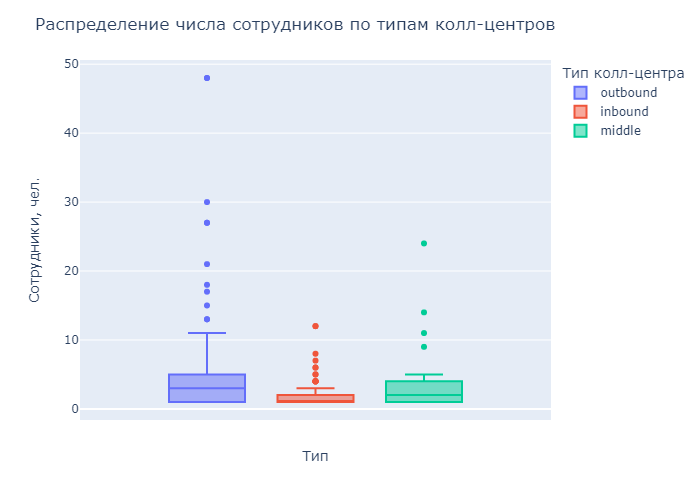

In [45]:
fig = px.box(cc_type_ppl, y="operator_id", color='cc_type')
fig.update_layout(title="Распределение числа сотрудников по типам колл-центров",
                  yaxis_title="Сотрудники, чел.",
                 xaxis_title="Тип",
                 legend_title_text='Тип колл-центра')
fig.show("png")

Диаграммы размаха показывают, что КЦ, работающие с входящими обращениями, самые маленькие - максимум в них встречается 12 операторов. Наиболее распространенные значения - от 1 до 3 человек.

Для "середнячков" число сотрудников чуть выше и максимально в них может работать 24 человека, но самые часто встречающиеся - от 1 до 5 операторов.

Колл-центры, работающие по исходящим звонкам - самые многочисленные: их не просто больше по количеству, как мы установили ранее, но и в них работает больше всего людей: до 48 человек. Но самые часто встречающиеся насчитывают от 1 до 11 операторов.

### Характеристики показателей по тарифным планам

Аналогичным типам колл-центров образом рассмотрим основные показатели по тарифным планам.

In [46]:
tariff_gen = df.query('internal == False').pivot_table(index=['tariff_plan','direction','is_missed_call'],values=['user_id','operator_id','calls_count','call_duration','total_call_duration','wait_time'],
                                                     aggfunc={'user_id':'nunique',
                                                              'operator_id':'nunique',
                                                              'calls_count':'sum',
                                                              'call_duration':'mean',
                                                              'total_call_duration':'mean',
                                                              'wait_time':'mean'}).reset_index()
tariff_gen

,tariff_plan,direction,is_missed_call,call_duration,calls_count,operator_id,total_call_duration,user_id,wait_time
0,A,in,False,973.230458,30919,176,1072.539757,29,99.309299
1,A,in,True,68.039216,374,72,85.839216,20,17.800000
2,A,out,False,4944.221101,189676,254,5877.106870,27,932.885769
3,A,out,True,0.000000,154078,255,1162.314633,27,1162.314633
4,B,in,False,856.292324,27791,274,983.623675,93,127.331352
5,B,in,True,14.714286,303,69,54.580357,37,39.866071
6,B,out,False,1433.254898,64401,282,1618.082951,82,184.828053
7,B,out,True,0.000000,42031,289,232.875462,86,232.875462
8,C,in,False,676.878548,33440,287,764.339942,151,87.461394
9,C,in,True,6.657609,224,90,27.233696,57,20.576087


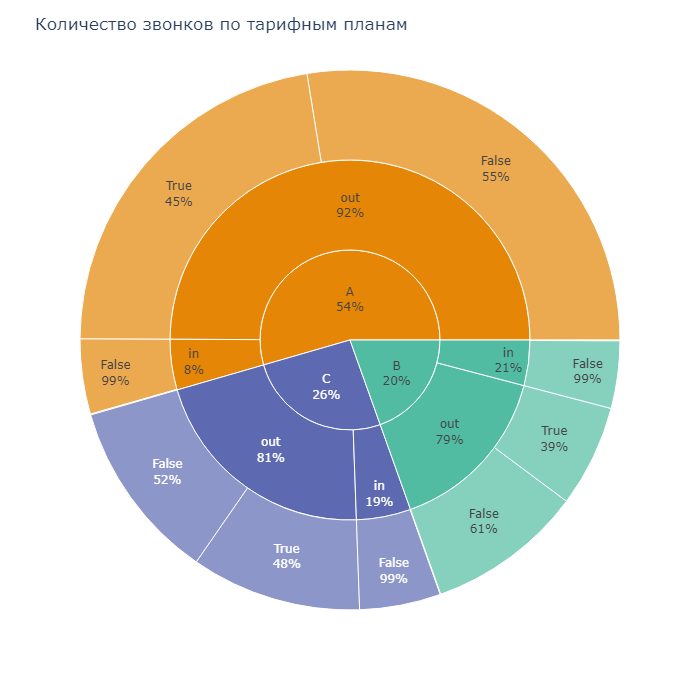

In [47]:
fig = px.sunburst(tariff_gen, path=['tariff_plan','direction', 'is_missed_call'], values='calls_count', color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_layout(title='Количество звонков по тарифным планам',
                  width=700,
                  height=700)
fig.update_traces(textinfo='label+percent parent', insidetextorientation='horizontal')
fig.show("png")

Распределение звонков по тарифным планам показывает, что все тарифные планы, в основном, работают на исходящие взаимодействия. Входящие звонки в них составляют от 8 до 21%, и из них 99% звонков принимаются и только 1% остается неотвеченным. 
* На тарифный план А приходится 54% всех звонков, из них входящих только 8%. 
* Тариф В - наименее распространенный по числу звонков, на него приходится 20% звонков и из них 21% входящих. 
* На тариф С приходится 26% всех звонков и из них 19% входящих.

В части распределения успешных и неуспешных вызовов среди исходящих звонков, для тарифа А не принимается 45% звонков, для тарифа С - 48% звонков, а для тарифа В - 39% звонков. 

Такие данные могут показывать, что для разных тарифов могут иметься разные условия работы операторов (к примеру, разной полноты и качества базы обзвона, "холодные" и "теплые" клиенты или иное), либо иной SLA, который установлен тарифным планом. Достоверно установить многие факты невозможно из-за отсутствия информации.

Одновременно с этим необходимо помнить, что самый распространенный по числу пользователей тарифный план - С (54,1%), на втором месте тариф В (34,8%), и на тариф А приходится всего 11% всех пользователей. Это дополняет предположение о том, что тарифные планы могут иметь некоторые внутренние параметры, влияющие на рассматриваемые показатели.

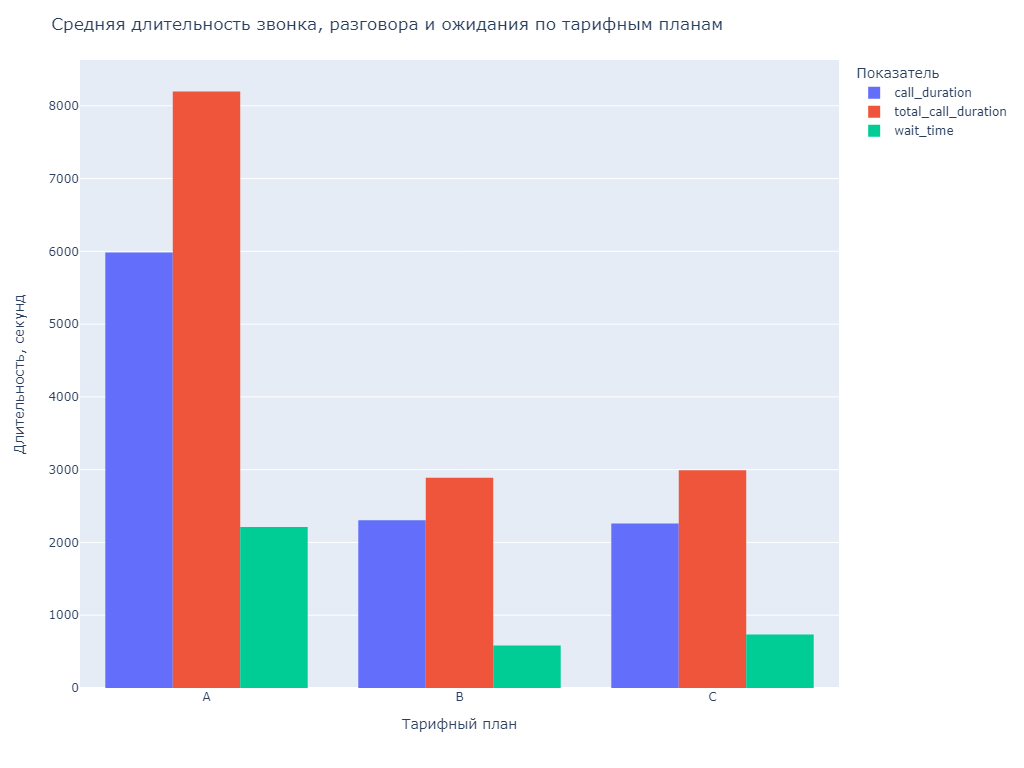

In [48]:
fig= px.histogram(tariff_gen, x="tariff_plan", y=['call_duration','total_call_duration','wait_time'],barmode='group')
fig.update_layout(width=1024,
                  height=768,
                    title='Средняя длительность звонка, разговора и ожидания по тарифным планам',
                   xaxis_title='Тарифный план',
                   yaxis_title='Длительность, секунд',
                 legend_title_text='Показатель')
fig.show("png")

Для разных тарифных планов наблюдается разная длительность и времени ожидания и длительности разговора. 

* Самый большой по количеству звонков тариф А показывает также и самую высокую среднюю продолжительность вызова - 8197.8 секунд (или 136.63 минут - чуть более двух часов) и самую высокую среднюю длительность ожидания ответа - 2212.31 секунд (или 36.87 минут). 

* Тарифные планы В и С показывают примерно одинаковое среднее время вызова и разговора (2889.16 и 2304.26 секунд для тарифа В и 2993.52 и 2259.17 секунд для тарифа С), а также примерно одинаковое среднее время ожидания ответа (584.90 и 734.35 секунд соответственно). 

Это наблюдение также может говорить о том, что колл-центры тарифов В и С работают с иными клиентскими базами и могут иметь иные задачи.

Длинные разговоры для исходящего обзвона часто связаны с проведением различного рода социологических опросов (например, в рамках проведения переписи населения, или опроса об использовании телевизора, радио и прочих средств массовой информации - в таких опросах длительность разговора может действительно быть значительной). Можно предположить, что тарифный план А ориентирован на подобные виды исходящего обзвона - для проведения опросов и прочего, что затрачивает действительно много времени. Остальные тарифные планы, судя по всему, ориентированы на иное взаимодействие с абонентами, в связи с чем средняя длительность звонка на них составляет не более 49 минут.

Также, возможно, тарифный план А задействован в обзвонах по стационарным телефонам, где нет ограничения на длительность соединения, как в мобильной связи, где соедниение может длиться либо 59.9 минут, либо 29.9 минут. Достоверно установить это неовзможно, поскольку нет информации о том, на какие телефонные номера совершаются вызовы.

In [49]:
tariff_ppl = df.query('internal == False').pivot_table(index=['user_id','tariff_plan'],values=['operator_id'],
                                                     aggfunc={'operator_id':'nunique'}).reset_index()
tariff_ppl

,user_id,tariff_plan,operator_id
0,166377,B,5
1,166391,C,2
2,166392,C,3
3,166399,C,1
4,166405,B,10
...,...,...,...
285,168583,B,2
286,168598,C,1
287,168601,C,2
288,168603,B,1


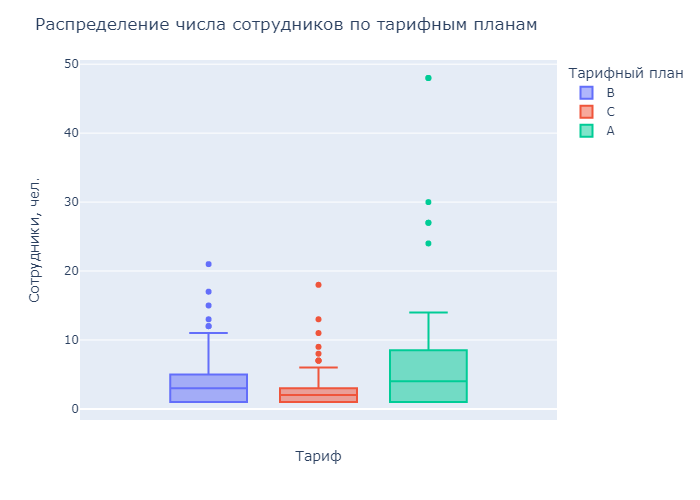

In [50]:
fig = px.box(tariff_ppl, y="operator_id", color='tariff_plan')
fig.update_layout(title="Распределение числа сотрудников по тарифным планам",
                  yaxis_title="Сотрудники, чел.",
                 xaxis_title="Тариф",
                 legend_title_text='Тарифный план')

fig.show("png")

Диаграммы размаха для числа сотрудников в зависимости от тарифного плана показывает, что в тарифе А задействовано чаще всего больше операторов, чем в двух других тарифах. 
* В тарифе А задействовано чаще всего от 1 до 14 операторов (макимально - 48), 
* В тарифе В - от 1 до 5 (максимально 21), 
* В тарифе С - от 1 до 3 (максимально 18). 

На основе этих диаграмм можно предположить, что тарифный план может зависеть от количества задействованных в колл-центре операторов (кроме уже вышеупоминавшейся направленности деятельности КЦ), но невозможно наверняка это утверждать, поскольку детальной информации о тарифных планах в нашем распоряжении нет.

### Выводы исследовательского анализа данных

По итогам проведенного исследовательского анализа данных можно определенно заявить, что представленный набор данных позволяет собрать только общую информацию о деятельности колл-центров и определить основные характерные параметры для колл-центров по тарифным планам и их основной направленности. 

- Представленные данные содержат в себе информацию о звонках для каждого колл-центра и оператора в день, **период сбора** информации лежит в границах с **02 августа 2019 года по 28 ноября 2019 года.** Рассматриваемые колл-центры **регистрировались в системе с 01 августа  по 31 октября 2019 года**. Соответственно, для последнего зарегистрированного КЦ может иметься информация о его активности в течение минимум 4 недель (для зарегистированного 31 октября КЦ может иметься информация о его звонках за 28 дней ноября). 

- **Исследование активности КЦ и операторов по датам** показывает, что **с течением времени число операторов и совершаемых ими звонков возрастало**, показывая временные снижения в выходные и праздничные дни.

- В динамике за все время исследования обнаружено, что **среднее время разговора и соединения со временем снижается**, а при принятии во внимание роста числа операторов, можно предположить, что они со временем обучаются более эффективному взаимодействию с абонентами для достижения поставленных перед ними задач.

- Среди всех пользователей сервиса **87% - колл-центры, работающие в основном по исходящим взаимодействиям**. Для **исходящих** взаимодействий характерно, что только **немногим более 50%** вызовов принимаются абонентами. Для **входящих** вызовов, **99% вызовов принимаются** и только 1% остается неотвеченным. Также, было определено, что **у колл-центров, работающих с исходящими вызовами, задействовано больше сотрудников (от 1 до 11 операторов), и среднее время разговора достигает 59 минут**. Остальные типы колл-центров показывают значительно меньшую длительность разговора и ожидания (19,53 и 4,47 минут).

- В рамках имеющихся данных о тарифных планах, было установлено, что **на тарифный план А приходится 54% звонков**, **тариф В** - **20% звонков** и **тариф С - 26% звонков**. Одновременно с этим, **тарифом С** пользуются **54,1%** клиентов компании, **тарифом В** - **34,8% клиентов**, и **тарифом А** - **11% клиентов**. **Число исходящих** вызовов по всем трем тарифам составляет **от 79% до 92%**, а **доля успешных** вызовов колеблется **в пределах 52-61%** от всех исходящих вызовов. Для **тарифа А** средняя длительность разговора составляет **99,75 минут**, для **тарифа В - 38,40 минут**, для **тарифа С - 37,65 минут**. По числу задейстованных операторов на тариф А приходится в основном от 1 до 14 операторов, для тарифа В - от 1 до 5 операторов, и для тарифа С - от 1 до 3 операторов.

Исследование показало, что **тарифный план клиента, скорее всего, выбирается в зависимости от числа задействованных КЦ операторов и длительности совершаемых ими вызовов**. При этом направление совершения вызовов при выборе тарифного плана не играет роли.

**Представленные данные дают только общую информацию** по работе пользователей сервиса "Нупозвони", и **не позволяют провести более детальный анализ**, чтобы выявить закономерности, которые могут оказывать влияние на работу клиента в тарифном плане или в направлении вызовов клиента.

Тем не менее, **полученные данные возможно использовать для общего анализа показателей конкретного выбранного колл-центра или оператора** для того, чтобы оценить их эффективность.

## Разработка метрики определения эффективности

В рамках исследовательского анализа данных выше было установлено, что с течением времени число операторов, колл-центров в сервисе и их активность возрастали, показывая некоторые спады в выходные дни. Поскольку имеющиеся данные охватывают промежуток между 01 августа и 28 ноября 2019 года, с последним зарегистрировавшимся в сервисе колл-центром 31 октября 2019 года.

Согласно отраслевым стандартам для колл-центров, которые были разработаны в 1996 году группой компаний Microsoft, Intel, American Express, Dell, Motorola, Novell и описанным компанией COPC Inc. (Customer Operations Performance Center Inc.), большинство метрик для колл-центров долны измеряться и оцениваться ежемесячно, поэтому для оценки будет рассматриваться период 1 месяца активности для всех имеющихся колл-центров (30 дней, предшествующих дате последнего совершенного звонка). При этом, список рассматриваемых метрик будет далек от рекомендуемого COPC, поскольку в предоставленных для анализа данных отсутствуют сведения о целях проведения исходящих обзвонов и результирующие данные для звонков, позволяющие оценить бизнес-эффективность проведенных коммуникаций.

Однако, принимая во внимание указанные выше рекомендации, для анализа отберем **данные для колл-центров, которые были зарегистрированы до 01 октября 2019 года (включая эту дату), и совершали звонки в промежутке между 01 и 31 октября.** Таким образом, в нашем распоряжении останутся данные за максимально полный октябрь 2019 года (поскольку имеются данные только за 28 дней ноября), и на основе этих данных мы сможем оценить основные показатели эффективности для имеющихся в этот период операторов и колл-центров.

### Основные используемые метрики эффективности

**Метрики для входящих взаимодействий**:
- Среднее время ожидания на линии. 
- Количество вызовов за период.
- Доля непринятых вызовов.
- Длительность разговора.
- Время активности оператора - разница между первым и последним звонком за период.

**Метрики для исходящих взаимодействий**:
- Среднее время ожидания на линии.
- Количество вызовов за период.
- Доля успешных вызовов.
- Длительность разговора.
- Время активности оператора - разница между первым и последним звонком за период.

При рассмотрении метрик для входящих и исходящих взаимодействий следует принимать во внимание, что существуют общемировые отраслевые практики для входящих взаимодействий, поскольку они напрямую завязаны на клиентский опыт и комфорт взаимодейстия клиента с колл-центром. Поэтому в части входящих взаимодействий будут применяться следующие пороговые значения:

- Время ожидания - в среднем 28 секунд
- Длительность разговора - в среднем 4 минуты (или 240 секунд)
- Доля пропущенных вызовов - от 5% до 8%

Количество вызовов и время занятости оператора работой необходимо оценивать индивидуально в зависимости от направленности колл-центра и рода его деятельности.

Для исходящих взаимодействий средние значения должны определяться маркетинговой или клиентской службой заказчика обзвона, поэтому метрики будут измерены без пороговых значений.

Для начала подготовим общий датасет для исследования звонков по указанному выше периоду. 

In [51]:
df_oct = df.query('date_start <= "2019-10-01" & date >= "2019-10-01" & date <= "2019-10-31"')
df_oct

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_time,cc_type
240,166377,2019-10-01,out,False,880026,False,19,2023,2155,B,2019-08-01,132,outbound
241,166377,2019-10-01,out,False,880020,False,1,106,108,B,2019-08-01,2,outbound
242,166377,2019-10-01,out,False,880026,True,3,0,102,B,2019-08-01,102,outbound
243,166377,2019-10-02,out,False,880026,True,3,0,69,B,2019-08-01,69,outbound
244,166377,2019-10-02,in,False,880026,False,3,556,568,B,2019-08-01,12,outbound
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30984,167819,2019-10-29,out,False,927916,True,1,0,27,C,2019-10-01,27,outbound
30985,167819,2019-10-29,out,False,927916,False,11,1484,1665,C,2019-10-01,181,outbound
30986,167819,2019-10-30,out,False,927916,False,8,1023,1142,C,2019-10-01,119,outbound
30987,167819,2019-10-30,out,False,927916,True,1,0,31,C,2019-10-01,31,outbound


### Метрики входящих взаимодействий

Для входящих взаимодействий рассмотрим только входящие звонки, которые не относятся к внутренним звонкам. Таким образом, отберем данные только по входящим взаимодействиям с "внешним миром".

In [52]:
df_in = df_oct.query('direction == "in" & internal == False')

In [53]:
op_in = df_in.pivot_table(index=['operator_id','is_missed_call'],
                  values=['date','calls_count','call_duration','wait_time'],
                  aggfunc={'date':['min','max'],
                          'calls_count':'sum',
                          'call_duration':'mean',
                          'wait_time':'mean'}).reset_index()
op_in.columns=['operator','missed','call_time_mean','total_calls','day_end','day_start','wait_time_mean']
op_in

,operator,missed,call_time_mean,total_calls,day_end,day_start,wait_time_mean
0,879896,False,47.500000,2,2019-10-19,2019-10-14,20.500000
1,879898,False,121.052632,44,2019-10-30,2019-10-01,45.526316
2,880022,False,13.000000,1,2019-10-15,2019-10-15,18.000000
3,880026,False,174.400000,9,2019-10-31,2019-10-02,7.600000
4,880028,False,106.000000,19,2019-10-31,2019-10-03,5.833333
...,...,...,...,...,...,...,...
432,944808,False,130.500000,12,2019-10-31,2019-10-23,5.000000
433,945710,False,50.000000,1,2019-10-24,2019-10-24,17.000000
434,946032,False,95.000000,1,2019-10-24,2019-10-24,8.000000
435,946916,False,57.750000,8,2019-10-30,2019-10-25,5.250000


В первую очередь необходимо определить долю пропущенных звонков у каждого оператора и дополнить таблицу соответствующим столбцом.

In [54]:
tmp = op_in.query('missed==True')
tmp=tmp.drop(columns=['missed','day_end','day_start'])
tmp.columns=['operator','missed_call_time_mean','total_missed','missed_wait_time_mean']

In [55]:
op_in=op_in.query('missed == False').drop(columns='missed').merge(tmp,how='left')
op_in=op_in.fillna(0)

In [56]:
def miss_share(row):
    tot = row['total_calls']
    mis = row['total_missed']
    if mis == 0:
        return 0
    else:
        result = round(mis/(tot+mis)*100,2)
        return result

In [57]:
op_in['miss_share'] = op_in.apply(miss_share,axis=1)

In [58]:
op_in['days_active']= (op_in['day_end'] - op_in['day_start']).dt.days +1
op_in=op_in.drop(columns=['day_end','day_start'])
op_in['call_time_mean']=round(op_in['call_time_mean'],2)
op_in['wait_time_mean']=round(op_in['wait_time_mean'],2)

In [59]:
# функция присвоения флага превышения норматива пропущенных
def cat_miss(row):
    miss = row['miss_share']
    if miss > 5:
        return 'High miss alert'
    else:
        return 'Normal'
op_in['miss_flag']=op_in.apply(cat_miss,axis=1)

# функция присвоения флага превышения норматива ожидания
def cat_waited(row):
    wait = row['wait_time_mean']
    if wait > 28:
        return 'Long wait alert'
    else:
        return 'Normal'
op_in['wait_flag']=op_in.apply(cat_waited,axis=1)

# функция присвоения флага превышения времени разговора
def cat_call(row):
    call = row['call_time_mean']
    if call > 240:
        return 'Long call alert'
    else:
        return 'Normal'
op_in['call_flag']=op_in.apply(cat_call,axis=1)

op_in

,operator,call_time_mean,total_calls,wait_time_mean,missed_call_time_mean,total_missed,missed_wait_time_mean,miss_share,days_active,miss_flag,wait_flag,call_flag
0,879896,47.50,2,20.50,0.0,0.0,0.0,0.0,6,Normal,Normal,Normal
1,879898,121.05,44,45.53,0.0,0.0,0.0,0.0,30,Normal,Long wait alert,Normal
2,880022,13.00,1,18.00,0.0,0.0,0.0,0.0,1,Normal,Normal,Normal
3,880026,174.40,9,7.60,0.0,0.0,0.0,0.0,30,Normal,Normal,Normal
4,880028,106.00,19,5.83,0.0,0.0,0.0,0.0,29,Normal,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
347,944808,130.50,12,5.00,0.0,0.0,0.0,0.0,9,Normal,Normal,Normal
348,945710,50.00,1,17.00,0.0,0.0,0.0,0.0,1,Normal,Normal,Normal
349,946032,95.00,1,8.00,0.0,0.0,0.0,0.0,1,Normal,Normal,Normal
350,946916,57.75,8,5.25,0.0,0.0,0.0,0.0,6,Normal,Normal,Normal


Как итог мы получаем общую таблицу по каждому оператору, где указаны: среднее время звонка, общее число звонков, среднее время ожидания, среднее время пропущенных звонков, общее число пропущенных звонков, среднее время ожидания для пропущенных звонков, доля пропущенных звонков и число дней активности. Также мы имеем возможность увидеть есть ли превышение норматива у того или иного оператора по времени ожидания, доле пропущенных звонков или по времени разговора.

Для того, чтобы рассмотреть данные по любому из операторов, эффективность которых изучается в отдельно взятом месяце, можно предложить следующий вывод:

In [60]:
#функция для вывода таблицы показателей по оператору

def show_in_stats():
    operator_id = int(input('Введите id оператора'))
    if operator_id in op_in['operator'].values:
        display(op_in.loc[op_in['operator']==operator_id].transpose())
    else:
        print('Оператор не найден')

In [61]:
show_in_stats() #для примера рекомендуется использовать оператора 880028

Введите id оператора880028


,4
operator,880028
call_time_mean,106.0
total_calls,19
wait_time_mean,5.83
missed_call_time_mean,0.0
total_missed,0.0
missed_wait_time_mean,0.0
miss_share,0.0
days_active,29
miss_flag,Normal


Таким образом, предполагая, что у заказчика есть список идентификационных номеров операторов (это может быть табельный номер, личный номер и прочее), можно предложить получать вывод по каждому интересующему оператору, если необходимо проверить персональную эффективность. Аналогичным образом, можно встроить результирующую таблицу (предварительно ее выгрузив) по всем операторам в систему управления эффективностью или в иной другой подобный дашборд, где будет показываться такая сводка.

**Дополнительный вывод операторов с предупреждающими флагами**

Поскольку для входящих взаимодействий мы имеем установленные флаги, можно вывести список всех операторов со сводными данными об их активности для наглядной демонстрации.

In [62]:
op_in.query('miss_flag == "High miss alert" & wait_flag == "Long wait alert" & call_flag == "Long call alert"')

,operator,call_time_mean,total_calls,wait_time_mean,missed_call_time_mean,total_missed,missed_wait_time_mean,miss_share,days_active,miss_flag,wait_flag,call_flag
23,888532,424.80,7,29.00,0.0,1.0,67.0,12.50,15,High miss alert,Long wait alert,Long call alert
26,888868,372.86,14,50.29,1.0,1.0,15.0,6.67,24,High miss alert,Long wait alert,Long call alert
148,906396,266.60,36,116.80,87.0,2.0,48.0,5.26,30,High miss alert,Long wait alert,Long call alert
196,912684,266.00,17,84.00,1.0,1.0,60.0,5.56,15,High miss alert,Long wait alert,Long call alert
280,924930,341.00,10,70.00,0.0,1.0,9.0,9.09,18,High miss alert,Long wait alert,Long call alert
324,932460,255.00,18,36.33,0.0,1.0,18.0,5.26,20,High miss alert,Long wait alert,Long call alert


Итого, в сервисе есть 6 операторов, которые одновременно показывают высокое время разговора, высокое время ожидания и высокую долю пропущенных вызовов. При этом, оценивая эффективность операторов, необходимо смотреть не только на критические триггеры, но в том числе и на иные параметры. К примеру, оператор 888532 принял всего 7 звонков и пропустил всего 1 звонок за 15 дней активности. Но в среднем на него пришлось по одному звонку в два дня, и для принятия управленческих решений необходимо дополнительно изучать применяемые к оператору требования SLA, а также его показатели по входящим звонкам. И для всех остальных операторов (учитывая ранее исследованый набор признаков для колл-центров) необходимо рассматривать их эффективность в разрезе задач, стоящих перед ним.

Дополнительно отобразим операторов, у которых есть хотя бы один критический триггер.

In [63]:
op_in.query('miss_flag == "High miss alert" | wait_flag == "Long wait alert" | call_flag == "Long call alert"')

,operator,call_time_mean,total_calls,wait_time_mean,missed_call_time_mean,total_missed,missed_wait_time_mean,miss_share,days_active,miss_flag,wait_flag,call_flag
1,879898,121.05,44,45.53,0.0,0.0,0.0,0.0,30,Normal,Long wait alert,Normal
5,882680,98.71,12,28.71,0.0,0.0,0.0,0.0,27,Normal,Long wait alert,Normal
6,882684,207.25,15,61.50,0.0,0.0,0.0,0.0,17,Normal,Long wait alert,Normal
7,882686,410.14,21,63.86,0.0,0.0,0.0,0.0,30,Normal,Long wait alert,Long call alert
8,882688,741.50,15,336.50,0.0,0.0,0.0,0.0,16,Normal,Long wait alert,Long call alert
...,...,...,...,...,...,...,...,...,...,...,...,...
339,940968,133.67,4,30.67,0.0,0.0,0.0,0.0,6,Normal,Long wait alert,Normal
341,943066,269.33,4,12.67,0.0,0.0,0.0,0.0,3,Normal,Normal,Long call alert
344,944644,52.00,2,99.00,0.0,0.0,0.0,0.0,1,Normal,Long wait alert,Normal
346,944648,26.00,2,42.00,0.0,0.0,0.0,0.0,1,Normal,Long wait alert,Normal


Оказывается, что таких операторов 237 из общего количества 352 операторов, работавших с входящими звонками. Принимая во внимание вышеописанную позицию о том, что управленческие решения необходимо принимать в совокупности исследуемых показателей и с учетом поставленных задач, нельзя говорить о том, что какой-либо из этих операторов может быть неэффективным, основываясь исключительно на трех триггерах.

### Метрики исходящих взаимодействий

Аналогично метрикам входящих взаимодействий измерим такие же метрики для исходящих взаимодействий. Скорее всего, картина будет совсем другая. Также, в создании набора показателей для оператора не будут применяться никакие маркеры, поскольку критичность того или иного показателя должен определять сам заказчик исходящего обзвона.

Как и на прошлом этапе, отберем только входящие звонки и только звонки "во внешний мир", исключив внутренние коммуникации.

In [64]:
df_out = df_oct.query('direction == "out" & internal == False')

In [65]:
op_out = df_out.pivot_table(index=['operator_id','is_missed_call'],
                  values=['date','calls_count','call_duration','wait_time'],
                  aggfunc={'date':['min','max'],
                          'calls_count':'sum',
                          'call_duration':'mean',
                          'wait_time':'mean'}).reset_index()
op_out.columns=['operator','missed','call_time_mean','total_calls','day_end','day_start','wait_time_mean']


In [66]:
tmp = op_out.query('missed==True')
tmp=tmp.drop(columns=['missed','day_end','day_start'])
tmp.columns=['operator','missed_call_time_mean','total_missed','missed_wait_time_mean']

In [67]:
op_out=op_out.query('missed == False').drop(columns='missed').merge(tmp,how='left')
op_out=op_out.fillna(0)

In [68]:
op_out['miss_share'] = op_out.apply(miss_share,axis=1)

In [69]:
op_out['days_active']= (op_out['day_end'] - op_out['day_start']).dt.days +1
op_out=op_out.drop(columns=['day_end','day_start'])
op_out['call_time_mean']=round(op_out['call_time_mean'],2)
op_out['wait_time_mean']=round(op_out['wait_time_mean'],2)
op_out

,operator,call_time_mean,total_calls,wait_time_mean,missed_call_time_mean,total_missed,missed_wait_time_mean,miss_share,days_active
0,879896,274.50,20,53.83,0.0,8.0,47.000000,28.57,25
1,879898,3110.00,1592,878.65,0.0,805.0,795.318182,33.58,31
2,880020,88.50,2,2.00,0.0,0.0,0.000000,0.00,3
3,880022,317.33,10,6.83,0.0,1.0,6.000000,9.09,21
4,880026,1822.26,448,122.26,0.0,149.0,136.454545,24.96,31
...,...,...,...,...,...,...,...,...,...
351,945728,137.00,3,55.00,0.0,5.0,40.500000,62.50,1
352,950444,2412.50,11,81.00,0.0,10.0,96.500000,47.62,2
353,950672,678.00,5,76.00,0.0,3.0,59.000000,37.50,1
354,951332,11.00,1,9.00,0.0,0.0,0.000000,0.00,1


In [70]:
def show_out_stats():
    operator_id = int(input('Введите id оператора'))
    if operator_id in op_out['operator'].values:
        display(op_out.loc[op_out['operator']==operator_id].transpose())
    else:
        print('Оператор не найден')

In [71]:
show_out_stats() #для примера рекомендуется использовать оператора 880028

Введите id оператора880028


,5
operator,880028.000000
call_time_mean,1688.230000
total_calls,446.000000
wait_time_mean,183.410000
missed_call_time_mean,0.000000
total_missed,287.000000
missed_wait_time_mean,349.636364
miss_share,39.150000
days_active,30.000000


Благодаря используемой выше функции, при требовании изучить показатели того или иного оператора за месяц, путем ввода его табельного или любого другого идентификационного номера, получаем общую сводку по сотруднику: среднее время звонка, число успешных звонков, ожидания ответа, число непринятых вызовов, среднее время ожидания непринятого вызова, долю непринятых вызовов и количество дней с момента первого звонка до момента последнего звонка.

**Ввиду отсутствия конкретного SLA** для операторов, **сформировать триггеры** для определения превышения нормативных показателей **невозможно**.

### Итоги исследования эффективности операторов

В данном разделе были сформированы **таблицы показателей** для операторов, **отдельно для исходящих и входящих вызовов**. Ввиду недостаточности данных, позволяющих конкретизировать эффективность оператора, для исходящих вызовов **частично были применены отраслевые стандарты**, и на основе их были сформированы дополнительные поля, которые возвращают предупреждение при превышении норматива.

**В части же остальных показателей** входящих вызовов (число принятых и пропущенных вызовов, время активности), а также всех показателей исходящих вызовов, **сформировать конкретные метрики**, которые автоматически будут указывать на провалы в работе оператора, **невозможно**.

Это может быть обусловлено тем, что **для каждого исходящего** обзвона заказчик формирует **свой определенный SLA**, в котором указывает число звонков в день, предельную длительность звонка, норматив по успешным и неуспешным вызовам и так далее. Поэтому, **рассматривать каждого оператора необходимо либо индивидуально** (для чего и выведена общая таблица показателей по оператору), **либо в совокупности с пользователем (колл-центром)**, который использует труд данного оператора, либо нескольких операторов. 

С точки зрения пользователя, необходимо иметь информацию по всем задействованным у него операторам, и эта **информация должна показываться в**, к примеру, **личном кабинете**, что решается с помощью создания соответствующего дашборда или иного программного продукта, встроенного в оболочку личного кабинета и имеющего возможность установить параметры собственного SLA для оценки нормативности показателей.

## Проверка гипотез

В рамках исследования были определены основные закономерности в различных колл-центрах в зависимости от их направленности. Подобные закономерности могут вызывать самые разнообразные гипотезы, однако самые очевидные среди них следующие:

1. Н0: Среднее число звонков (вне зависимости от направления) у оператора колл-центра по исходящим звонкам не отличается от среднего количества звонков оператора колл-центра по входящим звонкам. Альтернативная гипотеза (Н1): среднее число звонков операторов колл-центров разной направленности различается.

**Мотивация для рассмотрения гипотезы:** Как правило, колл-центры с упором на входящие взаимодействия ориентированы на прием заявок/жалоб/иных данных и полученную информацию либо агрегируют по опросным листам, либо создают трабл-тикеты и запросы, направляя их в ответственные подразделения. Колл-центры, работающие по исходящим вызовам, как правило ориентированы на проведение разного рода опросов, рекламу предложений, а также иную деятельность. Время каждого звонка у них скорее всего будет больше, и, соответственно, число звонков, совершаемых оператором в день и за весь период, будет другим.

2. Н0: Среднее время разговора в колл-центрах по исходящим звонкам не отличается от среднего времени вызова в колл-центрах по входящим взаимодействиям. Н1: Среднее время разговора в колл-центрах по исходящим звонкам отличается от среднего времени вызова в колл-центрах по входящим взаимодействиям.

**Мотивация для рассмотрения гипотезы:** Аналогично предыдущей гипотезе, нужно проверить, насколько верно предположение о том, что время на звонок у разной направленности колл-центров разное.

Для проверки указанных выше гипотез будет использоваться двусторонний тест Стьюдента (t-test) с уровнем статистической значимости 5%, то есть, с 5%-ой вероятностью того, что гипотеза будет неверно отвергнута/принята.

### Проверка гипотезы о различии среднего числа звонков колл-центров по входящим и исходящим взаимодействиям

Для исследования установим следующие гипотезы:

**Н0:** Среднее число звонков (вне зависимости от направления) у оператора колл-центра по исходящим звонкам не отличается от среднего количества звонков оператора колл-центра по входящим звонкам. 

**Альтернативная гипотеза (Н1):** среднее число звонков операторов колл-центров разной направленности различается.

In [72]:
alpha = 0.05 # уровень статистической значимости
sample_1 = df[df['cc_type'] =='inbound']['calls_count']
sample_2 = df[df['cc_type'] =='outbound']['calls_count']

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(sample_1, sample_2, equal_var=False) 

# вывод значения p-value на экран 
# условный оператор с выводом строки с ответом
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

6.530557485511538e-210
Отвергаем нулевую гипотезу


Полученные результаты проверки гипотезы показывают, что, скорее всего, среднее число звонков операторов колл-центров разной направленности различается. Как показало исследование данных в разделе **5.3**, действительно, колл-центры по исходящим обзвонам совершают значительно больше вызовов, но у них также и велик процент отказа, практически доходя до половины от общего количества.

Это объясняется поведенческими характеристиками абонентов, поскольку множество людей не любят, когда им досаждают "холодными звонками" или "социологическими опросами", не говоря уже о "службах безопасности". Поэтому, скорее всего, доля неуспешных вызовов настолько велика.

### Проверка гипотезы о различии среднего времени разговора в колл-центрах по входящим и исходящим взаимодействиям

Для исследования определим следующие гипотезы:

**Н0:** Среднее время разговора в колл-центрах по исходящим звонкам не отличается от среднего времени разговора в колл-центрах по входящим взаимодействиям. 

**Н1:** Среднее время разговора в колл-центрах по исходящим звонкам отличается от среднего времени разговора в колл-центрах по входящим взаимодействиям.

In [73]:
alpha = 0.05 # уровень статистической значимости
sample_1 = df[df['cc_type'] =='inbound']['call_duration']
sample_2 = df[df['cc_type'] =='outbound']['call_duration']

results = st.ttest_ind(sample_1, sample_2, equal_var=False) 

# вывод значения p-value на экран 
# условный оператор с выводом строки с ответом
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

1.269363013298777e-65
Отвергаем нулевую гипотезу


Результаты статистического теста показывают, что, скорее всего, среднее время вызова в колл-центрах различной направленности отличается. Это подтверждает выводы, сделанные в разделе **5.3** , где наглядно было показано, что среднее время разговора для колл-центров различной направленности отличается.

Как уже упоминалось, это обусловлено тем, что колл-центры с исходящим обзвоном чаще имеют б*о*льшее время разговора с абонентами, чем колл-центры входящего взаимодействия.

### Выводы по итогам проверки гипотез

Проверив две гипотезы, мы получили статистическое подтверждение уже ранее показанным наглядно различиям между колл-центрами в зависимости от их специализации. 

Тем не менее, в отдельных случаях, поскольку берутся случайные выборки, может оказаться, что у некоторых операторов или колл-центров (пользователей) средние значения параметров будут близки к равенству. Подобную погрешность необходимо всегда иметь в виду при сравнении различных величин.

## Финальные выводы и рекомендации

По итогам проведенного исследования звонков клиентов компании "Нупозвони", было установлено, что **имеющиеся данные ставят достаточно серьезные ограничения в их исследовании**, при условии использования отраслевого подхода к анализу эффективности операторов компании, а именно: **нет установленных рамок SLA по нормативным количествам звонков, их успешности, длительности дозвона и разговора и прочему**. Кроме того, отсутствуют значимые в отрасли метрики в части исследования клиентского опыта взаимодействия с оператором (NPS) и иные данные, которые могут сделать картину по сотруднику более полной.

- В общем разрезе было определено, что в данных представлен **период времени с 01 августа по 28 ноября 2019 года, последний зарегистрированный пользователь сервиса был 31 октября 2019 года.**

- Операторы совершают **86,6% исходящих вызовов против 13,4% входящих**, из всего количества только **1,95% вызовов внутренние**, но достаточно велико на общем фоне **количество пропущенных вызовов - 38,8%** по той или иной причине.

- В датасете есть **54.1% колл-центров с тарифом С, 34,8% колл-центров с тарифом В и 11% колл-центров с тарифом А**. Среди всех колл-центров **49,7% ориентированы на исходящий обзвон, 40% - на входящие звонки, и 10,3% работают со звонками обоих типов** При этом, определенный **тариф и направленность колл-центра не связаны между собой**, и тарифный план скорее **может зависеть от количества задействованных операторов, времени работы колл-центра, либо специфического SLA**. В этой части данных заказчиком не предоставлено, поэтому предположение выше является сугубо эмпирическим.

- За весь период исследования наблюдается **постоянный рост количества задействованных операторов по всем дням недели**. При этом **в выходные и праздничные дни число активных операторов значительно ниже, чем в будни**. Это, скорее всего, обусловлено трудовым законодательством, которое подразумевает повышенную оплату труда в выходные и праздники.

- **Средняя длительность звонков** с течением времени **имеет тенденцию к снижению**, что может говорить как о переходе количества звонков в их качество, либо о том, что операторы сервиса со временем учатся более эффективно использовать время звонка для достижения его цели.

- При разделении колл-центров по их основной направленности, было установлено, что **87% всех звонков** за время исследования приходятся на **колл-центры исходящего взаимодействия**. На втором месте идут колл-центры двусторонней направленности, и на третьем - колл-центры входящего взаимодействия. При этом, **входящие и исходящие звонки совершаются в каждом из типов колл-центров**, и в каждом из них **99% входящих звонков принимаются**, и более 55% исходящих вызовов принимаются абонентами. Также было установлено, что **в колл-центрах исходящего взаимодействия работает чаще всего от 1 до 11 операторов**, в то время как **для колл-центров входящего взаимодействия** это число находится чаще всего в промежутке **от 1 до 3 человек**.

- При исследовании **тарифных планов**, было установлено, что все они, в основном, работают на исходящие взаимодействия. **Входящие звонки в них составляют от 8 до 21%**, и из них 99% звонков принимаются и только 1% остается неотвеченным. При этом интересно обратить внимание, что **самый распространенный по числу звонков тарифный план - А**, на него приходится **54% всех звонков**, из них входящих только 8%. **Тариф В - наименее распространенный**, на него приходится **20% звонков** и из них 21% входящих. На **тариф С** приходится **26% всех звонков** и из них 19% входящих. В **тарифе А** задействовано чаще всего больше операторов, чем в двух других тарифах: **от 1 до 14 операторов (максимально - 48)**, **в тарифе В - от 1 до 5 (максимально 21), а в тарифе С - от 1 до 3 (максимально 18)**. Для **тарифа А** средняя длительность разговора составляет **99,75 минут**, для **тарифа В - 38,40 минут**, для **тарифа С - 37,65 минут**. Поэтому, скорее всего, выбор тарифного плана может зависеть от длительности звонка, задействованных операторов, полноты базы обзвона, а также от индивидуального SLA.

- В части основной задачи исследования - **измерения эффективности операторов**, были сформированы **оценочные таблицы для операторов отдельно по входящим и отдельно по исходящим вызовам с горизонтом исследования - 1 месяц** (был выбран октябрь 2019 года как наиболее наполненный данными месяц, при этом не имеющий праздничных дней). Ввиду отсутствия конкретизированных вводных заказчика исследования, были применены (где возможно) общепринятые отраслевые методики оценки качества работы операторов, и сформированы "флаги" для обозначения превышения над нормой. В остальном были **сформированы таблицы с показателями каждого оператора**, что позволяет индивидуально оценивать показатели в зависимости от установленных для человека уровней нормативности и эффективности, а также мотивации.

- Проверка **статистических гипотез** о равенстве или неравенстве средних значений количества звонков и длительности разговоров у колл-центров разной направленности **подтвердила уже обозначенные наблюдения** об очевидной разнице.

**Рекомендации сервису**

Для проведения успешного анализа эффективности операторов сервиса "Нупозвони" необходимо:
- Предоставить информацию о наполнении того или иного тарифного плана;
- Предоставить данные об SLA для каждого колл-центра, либо тарифного плана, либо оператора;
- Дополнить данные информацией о клиентском опыте взаимодействия с оператором;
- Дополнить данные информацией о целях совершения звонка и достижении или недостижении цели звонка (к примеру, конверсия звонка в продажу, успешность заполнения опросного листа и т.д.);
- Дополнить данные информацией о рабочем времени оператора и времени совершения каждого звонка для корректной оценки загруженности оператора в течение рабочего дня;
- Для внутренних вызовов дополнить информацию о том, был ли вызов переведен оператором на следующую ступень взаимодействия или был совершен с иными целями в ущерб исполнению рабочих обязанностей.